# Project Description

This project is an implementation of the Deep Convolutional Neural Network for Expression Recognition (DeXpression). DeXpression is a deep learning architecture that was developed by researchers at the University of Kaiserslautern in Germany. The architecture has shown potential, beyond that of many previous methods, for accurately recognizing human expressions<sup>1</sup>.

In [8]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as O
import lasagne.init as I

fpX = np.float32

# Data

The data we are using to train our network comes from a challenge posted on Kaggle in 2012 to recognize human expressions. It consists of 48x48 grayscale images of faces that are labeled 0-6 for angry, disgust, fear, happy, sad, surprise, and neutral respectively. The training set has 28,709 labeled images, and the final test set (which was used to determine the winners of the competition) consisted of 3,589 labeled images<sup>2</sup>. We use the final test set as our validation set.

The data is presented in a three column CSV file where each row represents a labeled image. The first column is the emotion column and contains the labels for our data set. The labels are integers 0-6 for each of our emotion classifications. The second column contains the pixels. This column contains 2,304 space-delimited integers for each of the 48x48 images<sup>2</sup>. The final column describes whether the image is from the training set or from the final test set.

Manual observations of the data reveal that the images are widely varied and inconsistent in quality. The data represents many demographics for age and ethnicity. There are also several images in which the face is not oriented towards the camera. Several entries cut the face off at the edges or have the actor's hands in front of the face. Furthermore, some of the images contain watermarks or are merely portrayals of people such as cartoons and manikins. Ideally, a researcher would filter out poor images before proceeding. However, for the purpose of this exercise, we have left the training data mostly untouched. The hope is that quantity will help mitigate what the data lacks in quality.  

In [3]:
######################
# READ TRAINING DATA #
######################

class LoadData(object):
    
    def __init__(self, path, width, height):
        content = np.genfromtxt(path, delimiter=',', names=True, 
                                converters={'pixels': lambda a: np.fromstring(a, sep=' ', dtype='float32')},
                                dtype=[('emotion', '<i8'), ('pixels', 'object'), ('Usage', '|S16')])
        self.labs = content['emotion']
        self.sort = content['Usage']
        self.imgs = np.array([e for (i, e) in enumerate(content['pixels'])]).reshape((self.labs.shape[0], width, height))
        
    def getTrainingImgs(self):
        return self.imgs[self.sort == 'Training']
        
    def getTrainingLabs(self):
        return self.labs[self.sort == 'Training']
        
    def getValidateImgs(self):
        return self.imgs[self.sort == 'PrivateTest']
        
    def getValidateLabs(self):
        return self.labs[self.sort == 'PrivateTest']
        
        
loader = LoadData(os.getcwd() + '/data/fer2013.csv', 48, 48)
train_imgs = loader.getTrainingImgs()[:,np.newaxis,:,:]
train_labs = loader.getTrainingLabs()
valid_imgs = loader.getValidateImgs()[:,np.newaxis,:,:]
valid_labs = loader.getValidateLabs()

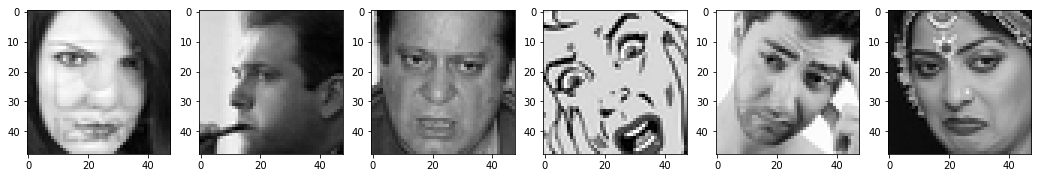

In [5]:
####################
# DISPLAY EXAMPLES #
####################

n = 6
plt.figure(figsize=(3*n,3))
for i in range(n):
    plt.subplot(1,n,i+1)
    idx = np.random.randint(0, len(train_imgs))
    plt.imshow(train_imgs[idx,0,:,:], cmap='gray')

In [9]:
####################
# HELPER FUNCTIONS #
####################

def embedding(x, c=10): 
    '''
    Also known as one-hot embedding.
    '''
    y = np.zeros((len(x), c), dtype=fpX)
    y[np.arange(len(x)), x] = 1
    return y

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    '''
    for a given 4d input image tensor and a 2d target tensor of one-hot embedding, 
    return a shuffled batch of input-target pair
    '''
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def print_lasagne_net(_net, skipnoparam=True):
    '''
    Print a summary of the layer and their parameter shapes
    '''
    layers = L.get_all_layers(_net)
    for l in layers:
        out = l.output_shape
        par = l.get_params()
        if skipnoparam and len(par)==0 and l.name==None:
            continue
        print "Layer\t: %s\nName\t: %s\nType\t: %s" % (l, l.name, type(l))
        print "Shape\t: %s" % (out,)
        if len(par)>0:
            print "Params"
            for p in par:
                print "        |-- {:<10}: {:}".format(p.name, p.get_value().shape,)
        print "\n"

# Network Architecture

DeXpression is an architecture that is "independent of any hand-crafted feature extraction and performs better than the earlier proposed convolutional neural network based approaches" for emotion recognition<sup>1</sup>. Convolutional neural networks are a subclass of artificial neural networks in which the neurons in a layer are only connected to a small region of the layer before it instead of being fully connected<sup>3</sup>. Convolutional neural networks are especially useful for feature extraction in images. Using an implementation in Caffe, the researchers that proposed DeXpression found that it had an average accuracy of 99.6% on their dataset. 

# Convolutional Neural Networks

Convolutional Neural Networks (CNNs) have neurons arranged in 3 dimensions: width, height, and depth. Every layer in a CNN transforms the 3D input volume to a 3D output volume of neuron activations. The dimensionality is reduced until the final output layer has 1x1xk, where k is the number of classifications<sup>3</sup>.

## Convolutional Layers

Convolutional layers in a network do most of the "computational heavy lifting"<sup>3</sup>. Their parameters are a set of learnable filters. Each filter is convolved across the width and height of the input volume and computes the dot products between the entries of the filter and the input at any position<sup>3</sup>. This creates a 2-dimensional activation map with responses for that filter at every spatial position. The network learns filters that activate when when they see certain visual features. Convolutional layers are built in to Lasagne making them relatively simple to implement. 

## Pooling Layers

Pooling layers progressively reduce the spatial size of the representation to help reduce computation in the network. It also helps maintain the generalization of the model. The pooling layer resizes every depth slice spatially using the MAX operation. Some researchers have suggested that pooling layers in CNNs are unnecessary<sup>4</sup>. Although DeXpression does include pooling layers, this might be an area in which adjustments could be made.

## Rectified Linear Unit

Rectified Linear Units (ReLU) employ an activation function called a rectifier. The rectifier, introduced in 2000 by Hahnloser, is now the most popular activation function for deep neural networks. As seen in the figure below, an ReLU is used for every convolutional layer in the DeXpression architecture.

## Normalization Layers

Normalization helps our network achieve increased sensory perception by creating contrast in certain areas. DeXpression utilizes several Local Response Normalization (LRN) layers. LRN layers are useful when dealing with RELU neurons because ReLU neurons have unbounded activations that need to be activated. Normalization around an excited neuron makes it more sensitive than its neighbors<sup>5</sup>.

# DeXpression Architecture


<img src="./network-architecture.png">

In [10]:
###################
# DEFINE CNN ARCH #
###################

npc = 1 # of channels in image
npx = 224 # number of pixels width/height of images
ny = 7 # of classes

def model(__X):
    '''
    Convolutional Neural Network description
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='Data')
    _convo1 = L.Conv2DLayer(_input, num_filters=64, filter_size=(ny,ny), stride=2, pad=3, name='Convolution 1')
    _pool1 = L.MaxPool2DLayer(_convo1, pool_size=3, stride=2, pad=0, ignore_border=False, name='Pooling 1')
    _lrn1 = L.LocalResponseNormalization2DLayer(_pool1, name='LRN 1')
    _featEx1 = featEx(_lrn1)
    _featEx2 = featEx(_featEx1)
    _classifier = L.DenseLayer(_featEx2, ny)
    return _classifier

def featEx(__X):
    '''
    Parallel Feature Extraction Block creates two parallel paths of features
    '''
    _convoA = L.Conv2DLayer(__X, num_filters=96, filter_size=(1,1), stride=1, pad=0, name='FeatEX Convolution a')
    _convoB = L.Conv2DLayer(_convoA, num_filters=208, filter_size=(3,3), stride=1, pad=1, name='FeatEX Convolution b')
    _poolA = L.MaxPool2DLayer(__X, pool_size=3, stride=1, pad=1, name='FeatEx Pooling a')
    _convoC = L.Conv2DLayer(_poolA, num_filters=64, filter_size=(1,1), stride=1, pad=0, name='FeatEX Convolution c')
    _concat = L.ConcatLayer([_convoB, _convoC], name='FeatEx Concat')
    _poolB = L.MaxPool2DLayer(_concat, pool_size=3, stride=2, pad=0, ignore_border=False, name='FeatEx Pooling b')
    
    return _poolB

In [11]:
####################
## THEANO COMPILE ##
####################

_X = T.tensor4() # a theano variable representing the input data
_Y = T.matrix() # a theano variable representing the class label

_cls = model(_X)
cls_params = L.get_all_params(_cls, trainable=True) # all trainable Theano shared params

print_lasagne_net(_cls, skipnoparam=False)

print cls_params

Layer	: <lasagne.layers.input.InputLayer object at 0x000000003991BD30>
Name	: Data
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 1, 224, 224)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x0000000042D16470>
Name	: Convolution 1
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 64, 112, 112)
Params
        |-- Convolution 1.W: (64L, 1L, 7L, 7L)
        |-- Convolution 1.b: (64L,)


Layer	: <lasagne.layers.pool.MaxPool2DLayer object at 0x0000000042D16588>
Name	: Pooling 1
Type	: <class 'lasagne.layers.pool.MaxPool2DLayer'>
Shape	: (None, 64, 56, 56)


Layer	: <lasagne.layers.normalization.LocalResponseNormalization2DLayer object at 0x0000000042D16048>
Name	: LRN 1
Type	: <class 'lasagne.layers.normalization.LocalResponseNormalization2DLayer'>
Shape	: (None, 64, 56, 56)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x0000000042D16080>
Name	: FeatEX Convolution a
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 96, 56, 56)
Param

In [19]:
def loss(__y):
    '''The loss function used to train the network -- tells what is good and what is bad'''
    return O.softmax(__y)

In [20]:
_lr = theano.shared(fpX(0))
_l2 = theano.shared(fpX(0))

_cls_reg = _l2 * R.regularize_layer_params(_cls, R.l2) # regularization loss
_cls_trn_pred = L.get_output(_cls, deterministic=False) # training prediction
_cls_trn_loss = loss(_cls_trn_pred, _Y) + _cls_reg # total training loss
_cls_trn_acc = T.mean(T.eq(T.argmax(_cls_trn_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_cls_val_pred = L.get_output(_cls, deterministic=True) #validation prediction
_cls_val_loss = loss(_cls_val_pred, _Y) + _cls_reg # total validation loss
_cls_val_acc = T.mean(T.eq(T.argmax(_cls_val_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_class = T.argmax(_cls_val_pred, axis=1)

cls_updates = lasagne.updates.sgd(_cls_trn_loss, cls_params, learning_rate=_lr) 
#cls_updates = lasagne.updates.apply_momentum(cls_updates, cls_params, momentum=0.9)

print 'COMPILING'
t = time.time()
cls_trn_fn = theano.function([_X, _Y], [_cls_trn_loss, _cls_trn_acc], updates=cls_updates)
cls_val_fn = theano.function([_X, _Y], [_cls_val_loss, _cls_val_acc])
cls_pred_fn = theano.function([_X], _class)
print '%.2f seconds to compile theano functions'%(time.time()-t)

AttributeError: 'module' object has no attribute 'squared_error'

In [12]:
lr = 1.   # initial learning rate for sgd
l2 = 0.    # l2 weight decay
niter = 5       # # of iter at starting learning rate
perc_decay = 5.0 # # of iter to linearly decay learning rate to zero
num_epochs = 5
batch_size = 1000
max_trn_size = 6000

_lr.set_value(fpX(lr))
_l2.set_value(fpX(l2))

trn_emb_label = embedding(train_labs, ny)
val_emb_label = embedding(valid_labs, ny)

trn_hist = []
val_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    trn_err = 0
    trn_acc = 0
    trn_batches = 0
    start_time = time.time()
    for xb, yb in tqdm(iterate_minibatches(train_imgs[:max_trn_size], trn_emb_label[:max_trn_size], batch_size, shuffle=False)):
        _, _ = cls_trn_fn(xb, yb)
    
    for xb, yb in iterate_minibatches(train_imgs[:max_trn_size], trn_emb_label[:max_trn_size], batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        trn_err += err
        trn_acc += acc
        trn_batches += 1
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for xb, yb in iterate_minibatches(valid_imgs, val_emb_label, batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        val_err += err
        val_acc += acc
        val_batches += 1

    trn_hist += [trn_acc / trn_batches,]
    val_hist += [val_acc / val_batches,]
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_batches))
    print("  training accuracy:   {:.2f} %".format(trn_acc / trn_batches * 100))
    print("  validation loss:     {:.6f}".format(val_err / val_batches))
    print("  validation accuracy: {:.2f} %".format(val_acc / val_batches * 100))
    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

0it [00:00, ?it/s]


NameError: name 'cls_trn_fn' is not defined

# Sources

[1] [DeXpression: Deep CNN for Expression Recognition](https://arxiv.org/pdf/1509.05371.pdf)

[2] [Kaggle dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion)

[3] [Stanford CS231 CNN](http://cs231n.github.io/convolutional-networks/)

[4] [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/pdf/1412.6806.pdf)

[5] [What is LRN in CNNs](https://prateekvjoshi.com/2016/04/05/what-is-local-response-normalization-in-convolutional-neural-networks/)

[6] [ImageNet Classification with Deep CNNs](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)